# Lab 02 - Computational Intelligence


In [9]:
import functools
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy.distance import geodesic
from tqdm.auto import tqdm

## Initialization

In [11]:
class Individual:
    def __init__(self, genome=None, fitness_score=None):
        self.genome = genome
        self.fitness = fitness_score

    def __repr__(self):
        return f"Fitness: {self.fitness}, {self.genome}"


# Function to read coordinates from a CSV file
def read_coor_csv(file_path):
    dtype_dict = {'city': 'string', 'lat': 'float64', 'lon': 'float64'}
    df = pd.read_csv(file_path, header=None, names=['city', 'lat', 'lon'], dtype=dtype_dict, low_memory=False)
    coords = df[['lat', 'lon']].values
    return coords


# Function to compute the distance matrix in kilometers
def dist_matrix(coords):
    dmat = np.zeros((len(coords), len(coords)), dtype=np.float64)
    for i, (x1, y1) in enumerate(coords):
        for j, (x2, y2) in enumerate(coords):
            dmat[i][j] = geodesic((x1, y1), (x2, y2)).km
    return dmat

## Helper Functions

In [12]:
def counter(fn):
    """Simple decorator for counting number of calls"""

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper


@counter
def cost(dmat, path):
    """Calculate total distance of the TSP path"""
    total_distance = 0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        total_distance += dmat[u][v]

    # Add starting point to close the loop
    u, v = path[-1], path[0]
    total_distance += dmat[u][v]

    return total_distance


def fitness(dmat, individual):
    return cost(dmat, individual.genome)

## Operators

In [13]:
def random_genome(length):
    genome = np.arange(length)
    np.random.shuffle(genome)
    return genome

def parent_selection(population, n=2):
    """Implement tournament selection"""
    selected_individuals = random.sample(population, n)
    return min(selected_individuals, key=lambda individual: individual.fitness)

def mutation_swap(p1):
    """Swap two cities"""
    new_genome = p1.genome.copy()
    idx1, idx2 = np.random.randint(0, len(new_genome), 2)
    new_genome[idx1], new_genome[idx2] = new_genome[idx2], new_genome[idx1]
    return Individual(new_genome)

def xover_order(p1, p2):
    """Order crossover"""
    length = len(p1.genome)

    # Choose cut-off points
    idx1, idx2 = np.sort(np.random.randint(0, length, 2))

    # Create offspring by copying the p1 genome between the cuts
    offspring = np.full((length,), -1)
    offspring[idx1:idx2] = p1.genome[idx1:idx2]

    # Fill the rest with p2 without repeating
    current_position = idx2 % length
    for gene in p2.genome:
        if gene not in offspring:
            offspring[current_position] = gene
            current_position = (current_position + 1) % length

    return Individual(offspring)

def mutation_inv(p1):
    """Reverse the order between cut-off points"""
    new_genome = p1.genome.copy()
    idx1, idx2 = np.sort(np.random.randint(0, len(new_genome), 2))

    new_genome = np.concatenate((new_genome[:idx1], new_genome[idx1:idx2 + 1][::-1], new_genome[idx2 + 1:]))
    return Individual(new_genome)


def mutation_multi(p1, prob_multi=0.5, prob_inv=0.5):
    """Apply the mutations multiple times"""
    new_ind = mutation_inv(p1) if np.random.random() < prob_inv else mutation_swap(p1)
    while np.random.random() < prob_multi:
        new_ind = mutation_inv(p1) if np.random.random() < prob_inv else mutation_swap(p1)
    return new_ind



## Resolution

In [ ]:
# Parameters
pop_size = 100
n_max_gen = 2000
offspring_size = pop_size * 3
p_mutation = 0.5
p_multi_mutation = 0.5
p_inv_mutation = 0.5
elitism = 1
plot_results = True

#Initializations
csv_file = 'cities/china.csv'
coords = read_coor_csv(csv_file)
dmat = dist_matrix(coords)

# Initial population
population = [Individual(random_genome(len(coords))) for _ in range(pop_size)]
for p in population:
    p.fitness = fitness(dmat, p)

bests = []

population.sort(key=lambda ind: ind.fitness)
bests.append(population[0])

for _ in tqdm(range(n_max_gen)):
    # Offspring generation
    offspring = []
    for _ in range(offspring_size):
        #randomly choose between multi mutation and crossover
        if np.random.random() < p_mutation:
            p = parent_selection(population)
            o = mutation_multi(p, p_multi_mutation, p_inv_mutation)
        else:
            p1 = parent_selection(population)
            p2 = parent_selection(population)
            o = xover_order(p1, p2)
        offspring.append(o)
    # Evaluate offspring
    for i in offspring:
        i.fitness = fitness(dmat, i)
    #pick the best individual from the population and add it to the offspring
    offspring.extend(population[:elitism])

    # Survivor selection
    population = offspring
    population.sort(key=lambda ind: ind.fitness)
    population = population[:pop_size]
    bests.append(population[0])

# Results
total_distance = cost(dmat, bests[-1].genome)
print(f"TSP Path: {bests[-1].genome}")
print(f"Total Distance Travelled: {total_distance}")
print(f"Cost calls: {cost.calls}")



  4%|▍         | 87/2000 [00:16<06:04,  5.25it/s]

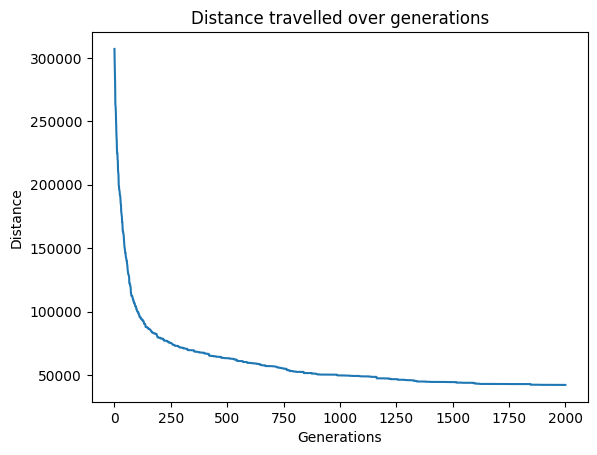

In [7]:
if plot_results:
    # Plot fitness
    plt.plot(np.array([i.fitness for i in bests]))
    # add a title
    plt.title('Distance travelled over generations')
    # add a label to the x-axis
    plt.xlabel('Generations')
    # add a label to the y-axis
    plt.ylabel('Distance')
    plt.show()